# Binäre Klassifizierung der Exzellenten Wikipedia Artikel

In [ ]:
! pip install transformers
! pip install pandas
! conda install numpy
! pip install imblearn
! pip install seaborn
! pip install textstat

# ONLY for apple slicon
!conda install pytorch torchvision torchaudio -c pytorch-nightly

In [1]:
# imports
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from transformers import BertTokenizer
import torch
from torch import nn
from transformers import BertModel

from torch.optim import Adam
from tqdm import tqdm

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

/Users/janmoormann/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# static var
CSV_FILE = "./articles_meta.csv"
TRAINED_MODEL = "./trained_model.pth"

## Regelbasierte Lösung
### Mauelle Feature Extraction und Decision Tree

Eine manuelle Lösung ist aufgrund der Komplexität und der nicht regelbasierten Auswahl der exzellenten Wikipedia Artikel durch die Wikipedia Community. Da die Artikel gewählt werden und ausschließlich grundsätzliche Guidelines gegeben sind. Daher wurde für die Lösung dieser Aufgabe ein regelbasierter Ansatz gewählt, welcher die Regeln auf der Basis einiger Features automatisiert Regeln erlernt. Dafür wurden zunächst manuelle Features und Metadaten extrahiert, welche anschließend in ein Decision Tree gegeben werden können. Der Decision Tree erlernt in dem Training eine Reihe an manuelle Regeln, anhand welcher anschließend die Artikel klassifiziert werden können.

### Feature Extraktion

Für den regelbasierten Ansatz wurden zunächt Features extrahiert, anahnd welcher anschließend klassifiziert werden soll.
Dies erfolgte auf der Grundlage von Wikipedia angegebenen besonderheiten von exzellenten Artiklen.

In [ ]:
# get number of words

# calculate TF-Idf



# get number of images
# calculated in the data preprocessing for better performance 

# get number of citations
# calculated in the data preprocessing for better performance 

### Data Balancing
Durchführen eines Undersamplings, sodass die selbe Anzahl Daten für exzellente und nicht exzellente Artikel in dem Datenset enthalten sind. Anschließend wird ein Split durchgeführt, in ein Trainings-, Test- und Validationdatensatz. Der Spilt ist (70/15/15).

In [10]:
original_meta_data = pd.read_csv(CSV_FILE, header=0, index_col=0)
X = original_meta_data.drop(['is_excellent','number_words'], axis=1)
Y = original_meta_data['is_excellent']

rus = RandomUnderSampler(random_state=42)
X, Y = rus.fit_resample(X, Y)
print('Klassenverteilung: %s \n' % Counter(Y))
X_train, X_test_val, Y_train, Y_test_val = train_test_split(X,Y, test_size=0.3, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test_val, Y_test_val, test_size=0.5, random_state=42)
print('Verteilung der Samples:')
print('  Trainingsdatenset: %s, Testdatenset: %s, Validationdatenset: %s' % (len(Y_train), len(Y_test), len(Y_val)))

Klassenverteilung: Counter({False: 1207, True: 1207}) 

Verteilung der Samples:
  Trainingsdatenset: 1689, Testdatenset: 362, Validationdatenset: 363


<Axes: >

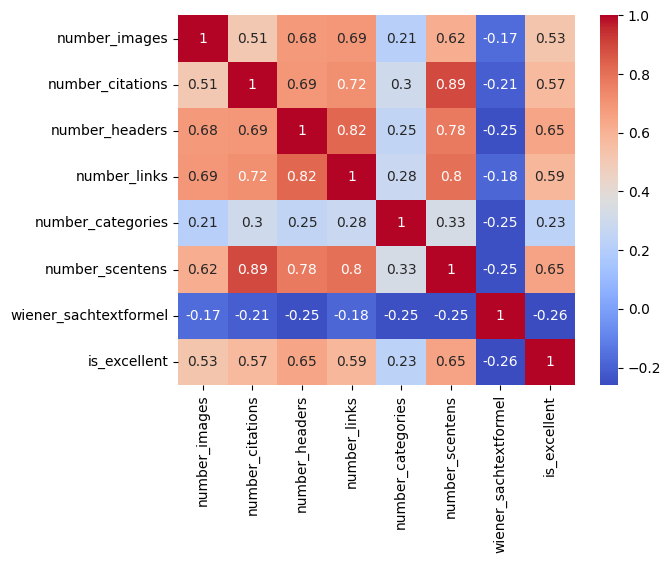

In [11]:
# display correlation matrix
df_undersample = pd.concat([X,Y], axis=1)
sns.heatmap(df_undersample.corr(), annot=True, cmap='coolwarm')

Bei der Coorelationsmatrix ist auffällig, dass die Anzahl der zugeordneten Kategorien mit keiner weiteren Variable stark korreliert. Die restlichen Variablen, aussgenommen das Label, korrelieren deutlich stärker miteinander. Das ist auf die Artikellänge, und der somit für alle Variablen abhänigen Anzahl zurückzuführen.
Das Label korreliert am stärksten mit der Anzahl der Titel in einem Artikel.

### Descision Tree

#### Training des Decision Tree

In [12]:
best_acc = 0
best_model = None

# fit decsision tree with hyperparameter optimization (grid search)
for criterion in ['gini','entropy']:
    for max_depth in [2,3,5,7,10,15]:
        for min_samples_leaf in [1,2,3,5,10,15]:
            for min_samples_split in [2,3,5,8,10,12,18,20]:
                # print current hyperparameter configuration
                print('-params- criterion: %s, max_depth: %s, min_samples_leaf: %s, min_samples_split: %s' % (criterion, max_depth, min_samples_leaf, min_samples_split))

                # initalize decision tree with hyperparameters
                decision_tree = tree.DecisionTreeClassifier(
                    criterion=criterion, 
                    max_depth=max_depth, 
                    min_samples_leaf=min_samples_leaf, 
                    min_samples_split=min_samples_split, 
                    random_state=42)
                
                # fit decision tree
                decision_tree = decision_tree.fit(X_train,Y_train)

                # calculate accuracy and check if it is the best model
                y_pred = decision_tree.predict(X_val)
                
                if(metrics.accuracy_score(Y_val, y_pred) > best_acc):
                    # save new best model and acc
                    best_model = decision_tree
                    best_acc = metrics.accuracy_score(Y_val, y_pred)
                    print('new best model with val-acc: %s' % best_acc)

# Model Test-Accuracy
y_pred = best_model.predict(X_test)
print("Best Model Test-Accuracy:", metrics.accuracy_score(Y_test, y_pred))


-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 2
new best model with val-acc: 0.9173553719008265
-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 3
-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 5
-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 8
-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 10
-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 12
-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 18
-params- criterion: gini, max_depth: 2, min_samples_leaf: 1, min_samples_split: 20
-params- criterion: gini, max_depth: 2, min_samples_leaf: 2, min_samples_split: 2
-params- criterion: gini, max_depth: 2, min_samples_leaf: 2, min_samples_split: 3
-params- criterion: gini, max_depth: 2, min_samples_leaf: 2, min_samples_split: 5
-params- criterion: gini, max_depth: 2, min_sa

#### Visualisierug der erlernten Regeln

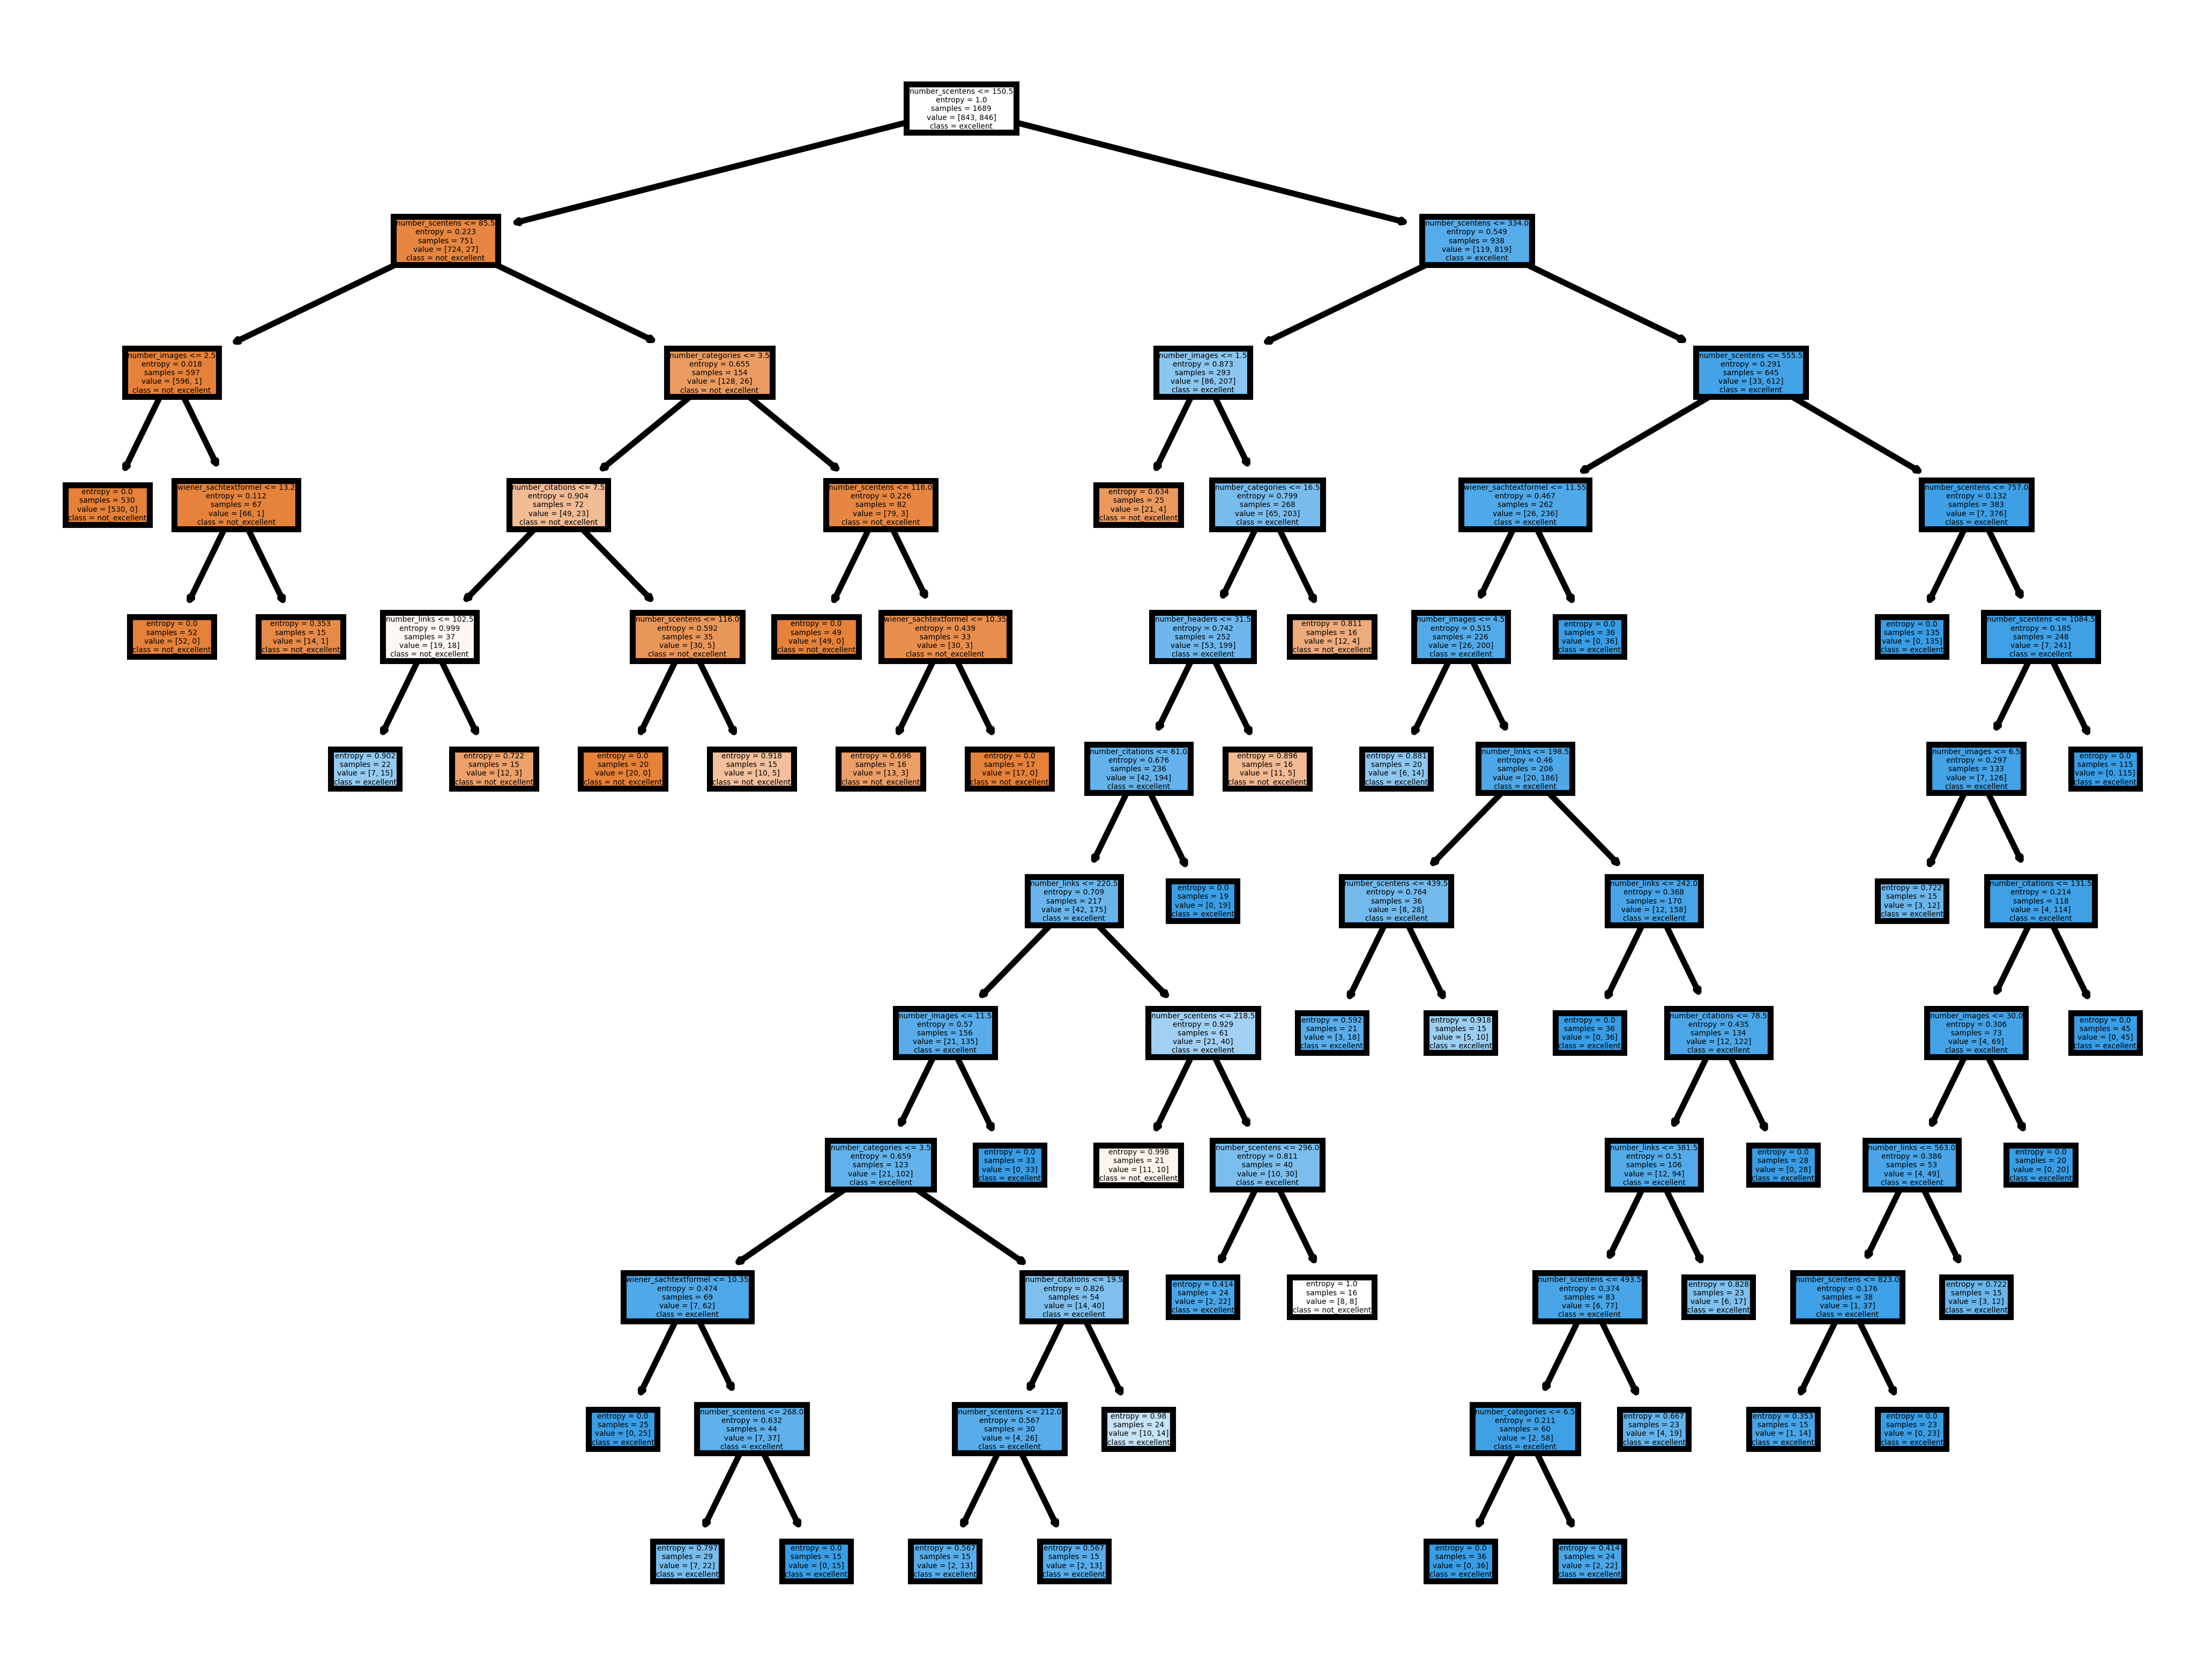

In [13]:
fig, axes = plt.subplots(dpi=800)

tree.plot_tree(decision_tree,
           feature_names = X.columns.values.tolist(), 
           class_names=['not_excellent', 'excellent'],
           filled = True)
fig.savefig("./explanation/tree_viz.png")

#### Evaluation

Test-Accuracy: 0.930939226519337
F1-Score: 0.9329758713136729


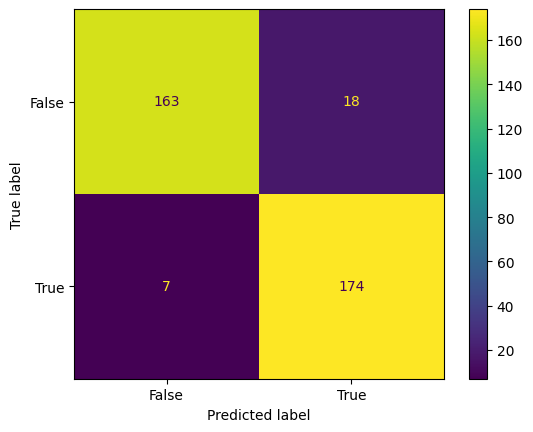

In [15]:

y_pred = best_model.predict(X_test)

# calculate accuracy
accuracy = metrics.accuracy_score(Y_test, y_pred)
print('Test-Accuracy: %s' % accuracy)

# calculate f1 score
f1 = metrics.f1_score(Y_test, y_pred, labels=best_model.classes_, average='binary', sample_weight=None)
print('F1-Score: %s' % f1)

# generate confusion matrix
cm = metrics.confusion_matrix(Y_test, y_pred, labels=best_model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=best_model.classes_)
disp.plot()

## Deep Learning Lösung
### BERT Classifier
Mit Änderungen entommen aus: https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f


#### Apple Silicon CPU / GPU
Check ob Apple Silicon Chips genutzt werden können

In [33]:
# test if m1 chip is used
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


#### Auswahl der Hyperparameter und Modelle

In [34]:
# random seed for re
np.random.seed(112)

## config tokenizer ##
# pretrained tokenizer model
PRETRAINED_TOKENIZER_MODEL_NAME = 'bert-base-german-cased' # 'bert-base-german-cased' for german or 'bert-base-multilingual-cased'
# size of output tensor
MAX_SEQUENZ_LENGTH = 512
#
PADDING = 'max_length'
#
TURNCATION = True
#
RETURN_TRNSORS = 'pt'

## training config ##
PRETRAINED_MODEL_NAME = 'bert-base-german-cased' # 'bert-base-multilingual-cased' # Best model for text in other language than english
EPOCHS = 10
LR = 1e-6

#### Tokenizer / aufbereitung der Artikel

In [35]:
# tokenzier for preprocessing the text
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_TOKENIZER_MODEL_NAME)
# output labels
labels = {'not_excellent':0,
          'excellent':1}


# demo of tokenizer function
example_text = ['Wikipedia', 'The Germann Wikipedia dump has a Size of 26GB']
bert_input = tokenizer(example_text,padding=PADDING, max_length = MAX_SEQUENZ_LENGTH, 
                       truncation=TURNCATION, return_tensors=RETURN_TRNSORS)

# tokenizer output => array[2]:
# 0. input_ids: id representation of each token
print(bert_input['input_ids'])
# 1. token_type_ids: binary mask that identifies in which sequence a token belongs
print(bert_input['token_type_ids'])
# 3. attention_mask: binary mask that identifies whether a token is a real word or just padding
print(bert_input['attention_mask'])

tensor([[    3, 15815, 16640,  ...,     0,     0,     0],
        [    3,  1233,  6594,  ...,     0,     0,     0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


### Datenset Klasse

In [37]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df) -> None:

        self.labels = [labels[label] for label in df['Label']]
        self.texts = [tokenizer(text, padding=PADDING, max_length = MAX_SEQUENZ_LENGTH, 
                       truncation=TURNCATION, return_tensors=RETURN_TRNSORS) for text in df['Text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [50]:
# generate df with text and label based on the split of decision tree
# iter train, test and val dataset
for idx, (x_dataset,y_dataset) in enumerate([(X_train,Y_train),(X_val, Y_val),(X_test,Y_test)]):
    # concat x and y
    dataset = pd.concat([x_dataset,y_dataset], axis=1)

    # empts lists
    list_text = []
    list_labels = []

    # iter all articles in dataset
    for article_id, article in dataset.iterrows():
        # get folder name based on label
        ordner = './data/exzellent' if article['is_excellent'] else './data/not_exzellent'
        # merge filename
        filename = str(article_id) + '.txt'
        # join filepath
        filepath = os.path.join(ordner, filename)
            
        # open file and read text
        with open(filepath, 'r') as f:
            text = f.read()
            f.close()

        # append text and label to lists
        list_text.append(text)
        lbl = 'excellent' if article['is_excellent'] else 'not_excellent'
        list_labels.append(lbl)
    
    # generate df based on dataset and list
    if idx == 0:
        df_train = pd.DataFrame({'Text': list_text, 'Label': list_labels})
    elif idx == 1:
        df_val = pd.DataFrame({'Text': list_text, 'Label': list_labels})
    else:
        df_test = pd.DataFrame({'Text': list_text, 'Label': list_labels})

print(len(df_train),len(df_val), len(df_test))

1942088
3452654
6109694
5138
190608
7610955
206336
5885605


FileNotFoundError: [Errno 2] No such file or directory: './data/not_exzellent/5885605.txt'

### Model class

In [21]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(PRETRAINED_MODEL_NAME)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    # forward network for classification
    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

### Laden des trainierten Modells
Alternativ kann auch ein bereits durch uns traniertes Modell geladen werden. Ein training und eine vollständige Datenaufbereitung ist somit nicht mehr notwendig.
Dafür muss der nachfolgende Code-Block ausgeführt werden. Danach kann direkt mit der Evaluierung fortgesetzt werden. 

In [ ]:
model = BertClassifier()
model.load_state_dict('trained_model.pth')

### Training Loop

In [22]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        model = model.to(device)
        criterion = criterion.to(device)
    elif use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()


    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
    return model

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/2151 [00:00<?, ?it/s]/Users/janmoormann/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated,

Epochs: 1 | Train Loss:  0.270                 | Train Accuracy:  0.000                 | Val Loss:  0.123                 | Val Accuracy:  0.000


100%|██████████| 2151/2151 [15:10<00:00,  2.36it/s]


Epochs: 2 | Train Loss:  0.101                 | Train Accuracy:  0.000                 | Val Loss:  0.093                 | Val Accuracy:  0.000


100%|██████████| 2151/2151 [14:05<00:00,  2.55it/s]


Epochs: 3 | Train Loss:  0.068                 | Train Accuracy:  0.000                 | Val Loss:  0.082                 | Val Accuracy:  0.000


100%|██████████| 2151/2151 [14:24<00:00,  2.49it/s]


Epochs: 4 | Train Loss:  0.043                 | Train Accuracy:  0.000                 | Val Loss:  0.086                 | Val Accuracy:  0.000


100%|██████████| 2151/2151 [16:00<00:00,  2.24it/s] 


Epochs: 5 | Train Loss:  0.028                 | Train Accuracy:  0.000                 | Val Loss:  0.086                 | Val Accuracy:  0.000


100%|██████████| 2151/2151 [14:28<00:00,  2.48it/s]


Epochs: 6 | Train Loss:  0.019                 | Train Accuracy:  0.000                 | Val Loss:  0.091                 | Val Accuracy:  0.000


100%|██████████| 2151/2151 [14:06<00:00,  2.54it/s]


Epochs: 7 | Train Loss:  0.011                 | Train Accuracy:  0.000                 | Val Loss:  0.108                 | Val Accuracy:  0.000


  8%|▊         | 172/2151 [01:09<12:54,  2.56it/s]

In [ ]:
model = BertClassifier()
model = train(model, df_train, df_val, LR, EPOCHS)
torch.save(model.state_dict(), TRAINED_MODEL)

#### Evaluierung / Test des Bert Modells


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        model = model.to(device)
    elif use_cuda:
        model = model.cuda()

    total_acc_test = 0
    pred = []
    target = []

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            # pred.append[output.argmax(dim=1)]
            # target.append[test_label]

            _, predicted = torch.max(output, 1)
            temp_true=labels.numpy()
            temp_pred=predicted.numpy()
            pred+=temp_true.tolist()
            target+=temp_pred.tolist()
    
    print(f'Test-Accuracy: {total_acc_test / len(test_data): .3f}')

    return pred, target

Test Accuracy:  0.946


In [ ]:
# run evaluation
pred, target = evaluate(model, df_test)

f1 = torch.torchmetrics.BinaryF1Score()
f1_score = f1(pred, target)

print('F1-Score: %s' % f1_score)

# Ergebnisse und Zusammenfassung